In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gp import *

from numpy.random import default_rng
from six.moves import cPickle as pickle #for performance
rng = default_rng()


In [2]:
def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [3]:
def calculate_acceleration_errors(data):
    v = data['v'][1:]
    v_pred = data['v_pred'][1:]
    a_error = (v - v_pred)/data['dt']
    a_validation = data['aero_drag'][1:]
    
    return a_error, a_validation

def subsample_for_training(z, y, n):
    n_sub = int(y.shape[0]/n)
    
    print(f'Number of subsamples = {n}')
    print(f'Size of feature training data before subsampling = {z.shape}')
    print(f'Size of output training data before subsampling = {y.shape}')

    
    z_train = z[::n_sub,:]
    y_train = y[::n_sub,:]
    
    print(f'Size of feature training data after subsampling = {z_train.shape}')
    print(f'Size of output training data after subsampling = {y_train.shape}')


    return z_train, y_train

def load_data():
    data = load_dict('trajectory.pkl')
    p = data['p'][1:,:]
    q = data['q'][1:,:]
    v = data['v'][1:,:]
    w = data['w'][1:,:]
    u = data['u'][1:,:]
    
    #print(data)
    return p,q,v,w,u

def subsample(z, reduction_factor):
    print(f'Subsampling by factor of = {reduction_factor}')

    z = z[::reduction_factor]
    return z

def shuffle_dataset(z, y):

    dataset = np.concatenate((z,y), axis=1) # concatenates along the state axis

    rng.shuffle(dataset)
    
    
    z = dataset[:,:-3]
    y = dataset[:,-3:]
    return z,y 

In [4]:
p,q,v,w,u = load_data()

# state vector
z = np.concatenate((p, q, v, w, u),axis=1)

# dependent variable
a_error, a_validation = calculate_acceleration_errors(load_dict('trajectory.pkl'))

# take a subset of data to reduce computation time during debugging
reduction_factor = 100

y = a_error 



# shuffles the data so that we can take a equidistant subsampling without loss of information
z,y = shuffle_dataset(z,y)


# takes every *reduction_factor* index along first axis 
z = subsample(z, reduction_factor)
y = subsample(y, reduction_factor)

# subsample further into *n* samples for training
z_train, y_train = subsample_for_training(z,y, 50)

# divide y into 3 seperate arrays for xyz dimensions
y_x, y_y, y_z = np.split(y_train, 3, axis = 1)
                         

Subsampling by factor of = 100
Subsampling by factor of = 100
Number of subsamples = 50
Size of feature training data before subsampling = (100, 17)
Size of output training data before subsampling = (100, 3)
Size of feature training data after subsampling = (50, 17)
Size of output training data after subsampling = (50, 3)


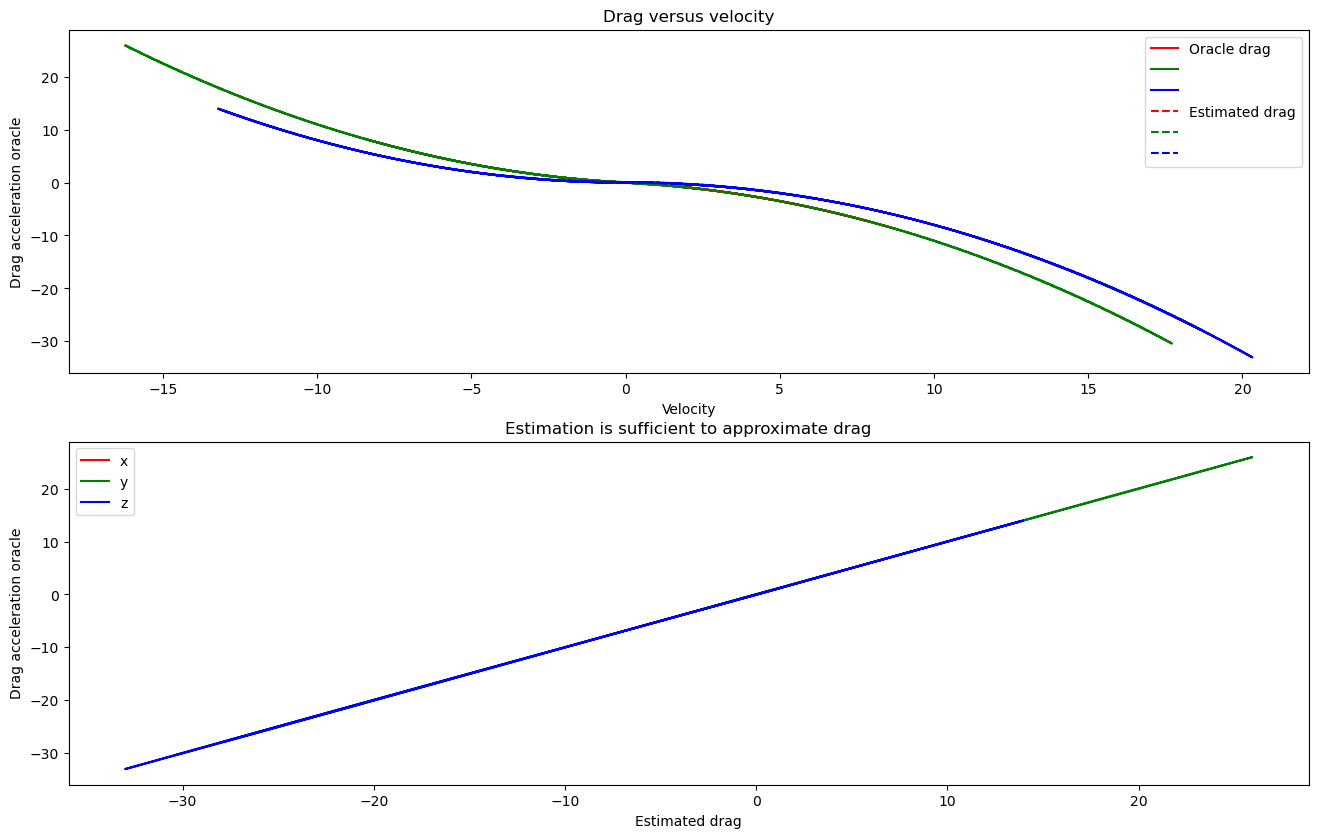

In [5]:
plt.figure(figsize=(16, 10), dpi=100)
plt.subplot(211)
plt.plot(v[:,0], a_validation[:,0], 'r', markerfacecolor='none')
plt.plot(v[:,1], a_validation[:,1], 'g', markerfacecolor='none')
plt.plot(v[:,2], a_validation[:,2], 'b', markerfacecolor='none')
plt.plot(v[:,0], a_error[:,0], 'r--')
plt.plot(v[:,1], a_error[:,1], 'g--')
plt.plot(v[:,2], a_error[:,2], 'b--')
plt.xlabel('Velocity')
plt.ylabel('Drag acceleration oracle')
plt.title('Drag versus velocity')
plt.legend(('Oracle drag','','', 'Estimated drag','',''))

plt.subplot(212)
plt.plot(a_error[:,0], a_validation[:,0], 'r')
plt.plot(a_error[:,1], a_validation[:,1], 'g')
plt.plot(a_error[:,2], a_validation[:,2], 'b')
plt.xlabel('Estimated drag')
plt.ylabel('Drag acceleration oracle')
plt.title('Estimation is sufficient to approximate drag')
plt.legend(('x', 'y', 'z'))


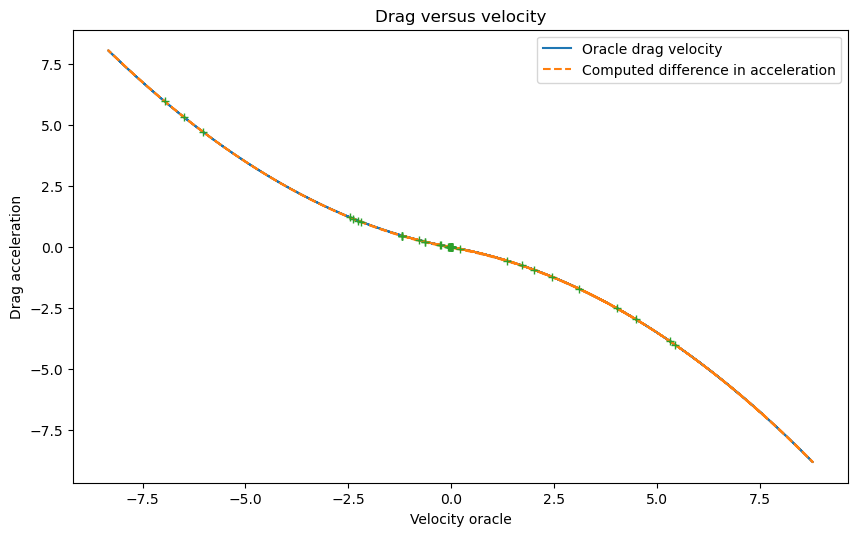

In [6]:
plt.figure(figsize=(10, 6), dpi=100)

plt.plot(v[:,0], a_validation[:,0], '-')
plt.plot(v[:,0], a_error[:,0], '--')
plt.plot(z_train[:,7], y_x, '+')
plt.xlabel('Velocity oracle')
plt.ylabel('Drag acceleration')
plt.title('Drag versus velocity')
plt.legend(('Oracle drag velocity', 'Computed difference in acceleration'))


In [44]:
kernel = RBF(L=np.eye(1)*theta_star[0], sigma_f=theta[1])
model = GPR(z_train, y_train, noise=theta_star[-1], covariance_function=kernel)


x_query = np.arange(-10,10,0.1).reshape(-1,1)
y_query = model.predict(x_query)

mean, var = model.predict(z, var=True)
print(mean.shape)
rms = np.sqrt(np.mean((y - mean)**2))
print(rms)

ValueError: shapes (1,17) and (1,1) not aligned: 17 (dim 1) != 1 (dim 0)

In [45]:
theta_star

      fun: array([-185.06047007])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.90717461e+00,  1.25403120e+00, -2.26205703e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 348
      nit: 35
     njev: 87
   status: 0
  success: True
        x: array([1.86516262e+00, 3.19761402e+00, 1.02159391e-06])

In [37]:
def nll(z_train, y_train, kernel):
    def nll_stable(theta):

        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        k = kernel(L=np.diag(theta[:-2]), sigma_f=theta[-2])
    
        K = calculate_covariance_matrix(z_train, z_train, k) + (theta[-1]+1e-7)*np.identity(z_train.shape[0])
        L = cholesky(K)

        S1 = solve_triangular(L, y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)

        return (np.sum(np.log(np.diagonal(L))) + \
               0.5 * y_train.T.dot(S2) + \
               0.5 * z_train.shape[0] * np.log(2*np.pi)).flatten()
    
    
    return nll_stable


In [54]:
theta0 = [1,1,1]

z_velx = z_train[:,7].reshape(-1,1) # just x velocity

kernel = RBF(L=np.eye(z_velx.shape[1])*theta0[0], sigma_f=theta0[1])
model = GPR(z_velx, y_x, noise=theta0[2], covariance_function=kernel)

## TODO ADD scipy.minimize as in http://krasserm.github.io/2018/03/19/gaussian-processes/
# also: http://gaussianprocess.org/gpml/chapters/RW2.pdf page 11

x_query = np.arange(-10,10,0.1).reshape(-1,1)
#print(x_query)
mean, std = model.predict(x_query, std=True)

print(mean.shape)
print(std.shape)

Size of feature training data = (50, 1)
Size of output training data = (50, 1)
(200, 1)
(200,)


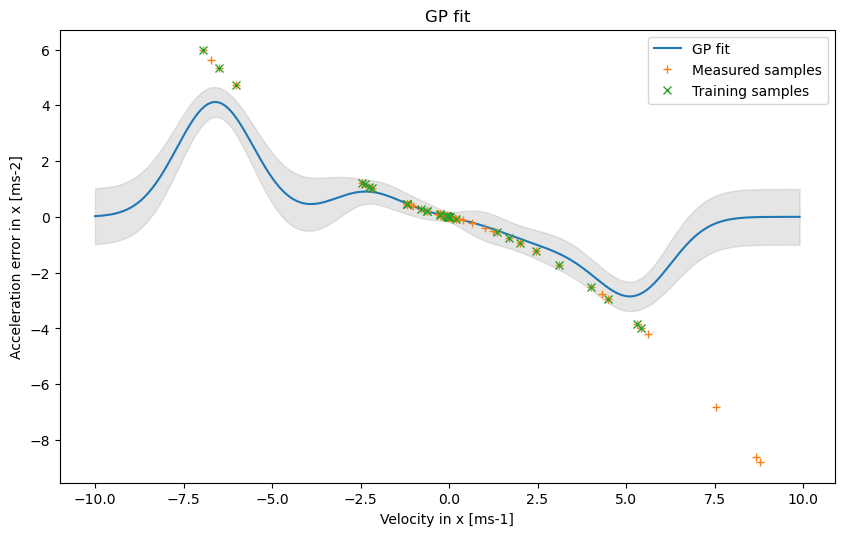

In [55]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(x_query, mean)
plt.plot(z[:,7], y[:,0], '+')
plt.plot(z_train[:,7], y_x[:,0], 'x')
plt.fill_between(x_query.reshape(-1), mean.reshape(-1) - std, mean.reshape(-1) + std,
                 color='gray', alpha=0.2)

plt.xlabel('Velocity in x [ms-1]')
plt.ylabel('Acceleration error in x [ms-2]')
plt.title('GP fit')
plt.legend(('GP fit', 'Measured samples', 'Training samples'))

In [51]:
# neg_log_fcn = nll(z_velx, y_x, RBF)

# l_possible = np.linspace(0.1,10,10)
# sigma_possible = np.linspace(1,5,10)
# likelyhood = np.empty((l_possible.shape[0], sigma_possible.shape[0]))
# for i in range(l_possible.shape[0]):
#     for j in range(sigma_possible.shape[0]):
#         likelyhood[i,j] = neg_log_fcn(np.array([l_possible[i], sigma_possible[j], 0.1]))
        
        

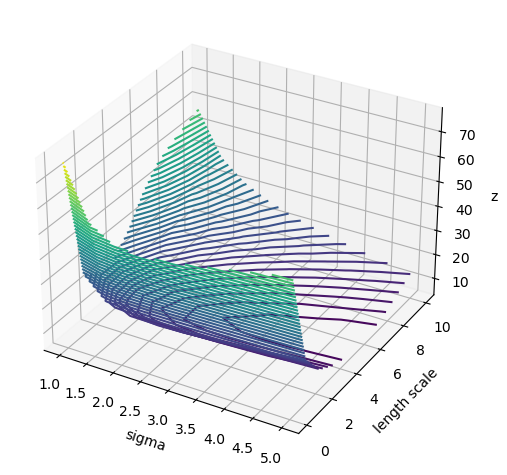

In [35]:
# X, Y = np.meshgrid(sigma_possible, l_possible)
# fig = plt.figure(figsize=(10,6), dpi=100)
# ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, likelyhood, 50)
# ax.set_xlabel('sigma')
# ax.set_ylabel('length scale')
# ax.set_zlabel('z');



In [56]:
from scipy.optimize import minimize

neg_log_fcn = nll(z_velx, y_x, RBF)

bnds = ((0, None), (0, None), (0, None))
sol_min = minimize(neg_log_fcn, x0=theta0, method='L-BFGS-B', bounds=bnds)
theta_star = sol_min.x

In [57]:
z_velx = z_train[:,7].reshape(-1,1) # just x velocity

kernel = RBF(L=np.eye(z_velx.shape[1])*theta_star[0], sigma_f=theta_star[1])
model = GPR(z_velx, y_x, noise=theta_star[2], covariance_function=kernel)

## TODO ADD scipy.minimize as in http://krasserm.github.io/2018/03/19/gaussian-processes/
# also: http://gaussianprocess.org/gpml/chapters/RW2.pdf page 11

x_query = np.arange(-10,10,0.1).reshape(-1,1)
#print(x_query)
mean, std = model.predict(x_query, std=True)

print(mean.shape)
print(std.shape)

Size of feature training data = (50, 1)
Size of output training data = (50, 1)


C:\Users\Ja\Desktop\gp\gp.py:23: RuntimeWarning: invalid value encountered in multiply
  cov_mat = np.empty((x1.shape[0], x2.shape[0]))*np.NaN


(200, 1)
(200,)


C:\Users\Ja\Desktop\gp\gp.py:81: RuntimeWarning: invalid value encountered in sqrt
  return mean_at_values, np.sqrt(variance)


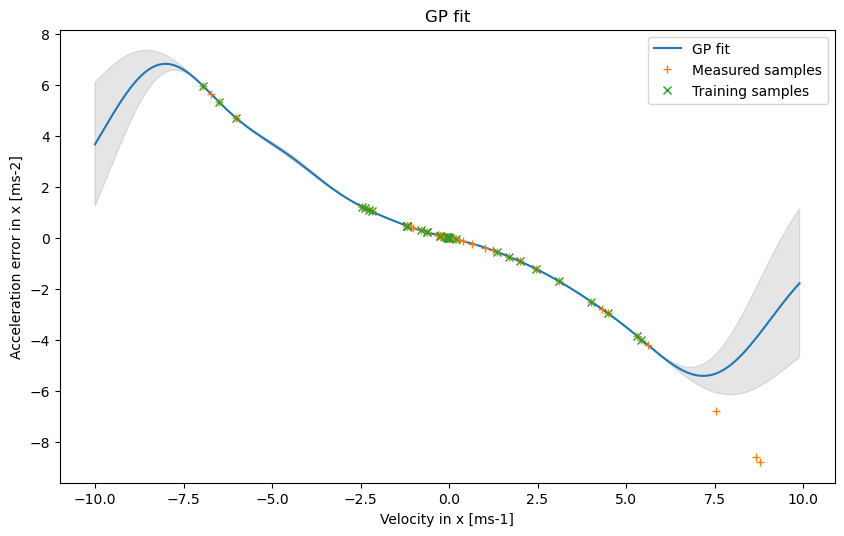

In [58]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(x_query, mean)
plt.plot(z[:,7], y[:,0], '+')
plt.plot(z_train[:,7], y_x[:,0], 'x')
plt.fill_between(x_query.reshape(-1), mean.reshape(-1) - std, mean.reshape(-1) + std,
                 color='gray', alpha=0.2)

plt.xlabel('Velocity in x [ms-1]')
plt.ylabel('Acceleration error in x [ms-2]')
plt.title('GP fit')
plt.legend(('GP fit', 'Measured samples', 'Training samples'))

In [42]:
print(theta_star)

      fun: array([-185.06047007])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.90717461e+00,  1.25403120e+00, -2.26205703e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 348
      nit: 35
     njev: 87
   status: 0
  success: True
        x: array([1.86516262e+00, 3.19761402e+00, 1.02159391e-06])


In [ ]:
kernel = RBF(L=np.eye(1))

model = GPR(z_train[:,8].reshape(1,-1), y_train, noise=0.1, covariance_function=kernel)


x_query = np.arange(-10,10,0.1).reshape(-1,1)
y_query = model.predict(x_query)

#mean, var = model.predict(v[:,0], var=True)
print(mean.shape)
rms = np.sqrt(np.mean((y - mean)**2))
print(rms)

In [ ]:
plt.figure()
plt.plot(z[:,8], mean,'+')

plt.plot(v[:,0], a_validation[:,0], 'r+')


In [ ]:

# kernel = RBF(L=np.eye(z_vel.shape[1])*10)
# model = GPR(v.reshape(-1,1), a_error.reshape(-1,1), noise=0.1, covariance_function=kernel)

# x_query = np.arange(-10,10,0.1).reshape(-1,1)
# print(x_query)
# mean = model.predict(x_query)

In [ ]:
plt.figure()
plt.plot(z_vel, y_train,'+')
plt.plot(x_query, mean)
plt.plot(v[:,0], a_error[:,0], 'r+')


In [ ]:
# sampling_ns = [3, 5, 10, 20, 50, 100]

# rms = np.empty((len(sampling_ns),))*np.NaN

# for i in range(len(sampling_ns)):
#     n_samples = sampling_ns[i]
#     n_sub = int(z_train.shape[0]/n_samples)
#     z_subsampled = z_train[::n_sub]
#     y_subsampled = y_train[::n_sub]
#     y_subsampled = y_subsampled.reshape((-1,1))
    
#     print(y_subsampled.shape)
#     kernel = SquaredExponentialKernel(L=np.eye(z_subsampled.shape[1]))

#     model = GPR(z_subsampled, y_subsampled, noise=0.0, covariance_function=kernel)
#     mean, var = model.predict(z_train, var=True)

#     rms[i] = np.sqrt(np.mean((y_train - mean)**2))

# rms

In [ ]:


plt.figure()
plt.plot(sampling_ns, rms)